# Importación de librerías

In [9]:
import pandas as pd
import numpy as np

import os
import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lectura del dataset

In [11]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos sobre los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv"

# Dataset CSV con metadatos consolidados
dataset_urbansound8k_vfinal_path_file = "../../data/final/dataset_urbansound8k_vfinal.csv"


In [12]:
# Lectura
dataset_urbansound8k_df = pd.read_csv(dataset_urbansound8k_vfinal_path_file, sep=";")

dataset_urbansound8k_df.head(3)

,classID,tasa_cruce_cero,entropia_espectograma,avg_centroide_espectral,fold,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,3,1947,6.716659,2503.702337,5,-275.91843,119.49280,-98.21178,-66.515140,-42.606050,0.505066,-28.330938,-5.746867,9.992785,4.795411,15.461894,-0.069880,-2.842674
1,2,27607,9.991457,2339.221804,5,-500.90840,185.10641,-86.53282,49.858850,9.230822,22.548956,-3.567175,12.220052,7.720082,-6.460391,16.995657,-6.625116,1.469779
2,2,20971,9.728703,2070.826863,5,-531.19530,186.93994,-70.34916,40.429245,9.121047,18.398588,6.283282,15.504061,9.613501,-7.113610,16.179823,-5.710522,-0.899251


In [13]:
# Columnas disponibles del dataset
dataset_urbansound8k_df.columns

Index(['classID', 'tasa_cruce_cero', 'entropia_espectograma',
       'avg_centroide_espectral', 'fold', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13'],
      dtype='object')

# Generación datos de entrenamiento y prueba

In [14]:
# Separar las características y la variable objetivo
# ['tasa_cruce_cero', 'entropia_espectograma', 'avg_centroide_espectral'
columnas_caracteristicas = ['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
             'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']

columna_predecir = 'classID'
columna_fold = 'fold'

# Separar las características y etiquetas
X = dataset_urbansound8k_df[columnas_caracteristicas]  # Suponiendo que 'classID' es la etiqueta y 'fold' el número de fold
y = dataset_urbansound8k_df[columna_predecir]
folds = dataset_urbansound8k_df['fold']

# Modelos de Clasificacion

## KNeighborsClassifier

In [ ]:
# Escalar los datos (opcional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir el modelo KNN
knn = KNeighborsClassifier()

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'n_neighbors': np.arange(1, 31),  # Número de vecinos a considerar
    'weights': ['uniform', 'distance'],  # Función de peso a usar
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métrica de distancia
}

# Inicializar lista para almacenar accuracies
fold_accuracies = []

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=knn, 
        param_distributions=param_distributions, 
        n_iter=10,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna con 5 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Obtener el mejor modelo
    best_knn = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation con KNN y RandomizedSearchCV')
plt.ylabel('Accuracy')
plt.show()


## Random Forest

Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.5393682436265215
Fold 1 Accuracy: 0.5063
Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.5502515273625374
Fold 2 Accuracy: 0.4178
Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.5345014609803342
Fold 3 Accuracy: 0.4454
Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.5306119863299159
Fold 4 Accuracy: 0.4253
Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.50781623383

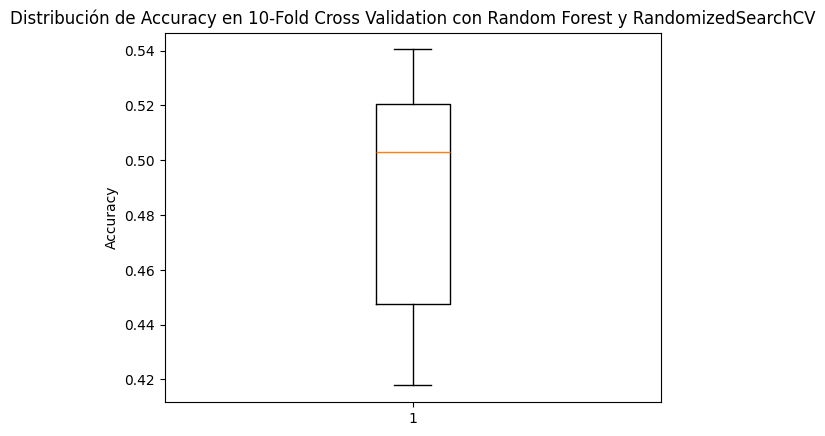

In [16]:
# Escalar los datos (opcional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir el modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'n_estimators': [10, 50, 100, 200, 500],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30, 40, 50],  # Máxima profundidad de cada árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras requeridas en una hoja
    'max_features': ['sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
    'bootstrap': [True, False]  # Método para seleccionar muestras para construir cada árbol
}

# Inicializar lista para almacenar accuracies
fold_accuracies = []

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=rf, 
        param_distributions=param_distributions, 
        n_iter=10,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna con 5 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Obtener el mejor modelo
    best_rf = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation con Random Forest y RandomizedSearchCV')
plt.ylabel('Accuracy')
plt.show()


## SVM

Fold 1 Accuracy: 0.5097
Fold 2 Accuracy: 0.3806
Fold 3 Accuracy: 0.4411
Fold 4 Accuracy: 0.4414
Fold 5 Accuracy: 0.5246
Fold 6 Accuracy: 0.4241
Fold 7 Accuracy: 0.5263
Fold 8 Accuracy: 0.5199
Fold 9 Accuracy: 0.5502
Fold 10 Accuracy: 0.5544

Accuracy promedio: 0.4872
Desviación estándar: 0.0571


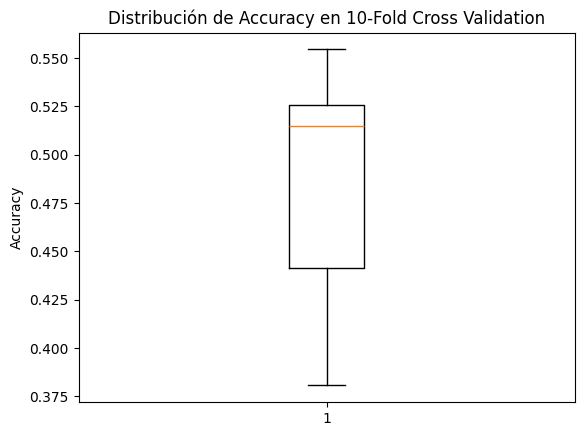

In [10]:
# Escalar los datos (opcional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir el modelo SVM
svm = SVC()

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'C': np.logspace(-3, 2, 6),  # Parámetro de regularización
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel
    'gamma': ['scale', 'auto'],  # Coeficiente del kernel 'rbf', 'poly' o 'sigmoid'
    'degree': np.arange(2, 6),  # Grado del polinomio si se usa kernel 'poly'
    'coef0': np.linspace(0, 1, 10)  # Término independiente en el kernel 'poly' y 'sigmoid'
}

# Inicializar lista para almacenar accuracies
fold_accuracies = []

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=svm, 
        param_distributions=param_distributions, 
        n_iter=10,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna con 10 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Obtener el mejor modelo
    best_svm = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation con SVM y RandomizedSearchCV')
plt.ylabel('Accuracy')
plt.show()
